In [1]:
!pip install matplotlib==3.5.1

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [7]:
# напишите запрос
query = '''
SELECT DISTINCT CAST(DATE_TRUNC('month',creation_date) AS date) AS month_date,                               
        SUM(views_count) OVER (PARTITION BY CAST(DATE_TRUNC('month',creation_date) AS date)) AS total_views  
FROM stackoverflow.posts                                                                                        
WHERE CAST(DATE_TRUNC('month',creation_date) AS date) BETWEEN '2008-01-01' AND '2008-12-01'                  
ORDER BY total_views DESC                                                                                    
'''

df1 = pd.read_sql_query(query, con=engine) 

In [8]:
df1

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

Отличия в кол-ве просмотров скорее всего связаны с началом работы stackoverflow: рост просмотров в июле, августе и пик в сентябре это запуск нового портала для программистов и по мере распространения информации о нем на него приходили посмотреть много интересующихся, а также просто любопытствующих, которые со временем начали "отваливаться" и этим можно объяснить снижение просмотров к концу 2008 года

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [9]:
# напишите запрос
query = '''
SELECT display_name,                                                                     
       COUNT(DISTINCT user_id)                                                          
FROM (                                                                                  
	SELECT DISTINCT p.user_id AS user_id,                                                
		   u.display_name,                                                               
    	   COUNT(p.id) OVER (PARTITION BY u.display_name) AS answer_qty,                 
    	   p.creation_date::date AS post_date,                                           
    	   u.creation_date::date AS reg_date                                            
	FROM stackoverflow.users AS u                                                        
	LEFT JOIN stackoverflow.posts AS p ON u.id=p.user_id                                 
	LEFT JOIN stackoverflow.post_types AS pt ON p.post_type_id=pt.id                     
	WHERE (pt."type" = 'Answer') AND (p.creation_date::date BETWEEN                         
                u.creation_date::date AND u.creation_date::date + INTERVAL '1 month')    
	ORDER BY u.display_name                                                              
	) AS info
WHERE answer_qty>100                                                                    
GROUP BY display_name                                                                   
ORDER BY 1;                                                                              
'''

df2 = pd.read_sql_query(query, con=engine) # выполните запрос


In [10]:
df2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Посмотрим на пользователей с кол-вом user_id больше 1:

In [11]:
query = '''
WITH inf AS (                                                                            
SELECT display_name,                                                                     
       COUNT(DISTINCT user_id) AS user_id_qty                                            
FROM (                                                                                   
	SELECT DISTINCT p.user_id AS user_id,                                               
		   u.display_name,                                                               
    	   COUNT(p.id) OVER (PARTITION BY u.display_name) AS answer_qty,                 
    	   p.creation_date::date AS post_date,                                           
    	   u.creation_date::date AS reg_date                                            
	FROM stackoverflow.users AS u                                                        
	LEFT JOIN stackoverflow.posts AS p ON u.id=p.user_id                                    
	LEFT JOIN stackoverflow.post_types AS pt ON p.post_type_id=pt.id                     
	WHERE (pt."type" = 'Answer') AND (p.creation_date::date BETWEEN                        
                u.creation_date::date AND u.creation_date::date + INTERVAL '1 month')    
	ORDER BY u.display_name                                                              
	) AS info
WHERE answer_qty>100                                                                    
GROUP BY display_name                                                                    
ORDER BY 1                                                                               
)
SELECT *                                                                                 
FROM inf                                                                                 
WHERE user_id_qty > 1                                                                        
'''

df3 = pd.read_sql_query(query, con=engine) # выполните запрос


In [12]:
df3

,display_name,user_id_qty
0,Alan,8
1,Brian,15
2,Chris,29
3,Craig,10
4,Dan,21
5,Greg,12
6,Jim,7
7,Joe,9
8,Josh,16
9,Keith,5


Какие аномалии наблюдаются в данных? О чём они говорят?

Как мы видим из таблицы выше несколько user_id у пользователей с простыми display_name, в которых присутствует только одно имя.Это значит что либо один и тот же человек регистрировался по несколько раз, либо другие пользователи использовали только имя для своей регистрации, а оно совпадало с ранее зарагистрированным.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [13]:
# напишите запрос
query = '''
SELECT date_trunc('month', p.creation_date)::date  AS "month",                       
       COUNT(info.id)                                                                  
FROM (                                                                               
    SELECT DISTINCT u.id,                                                            
			      date_trunc('month', u.creation_date)::date  AS reg_date,           
	   			  date_trunc('month', p.creation_date)::date AS post_date           
	FROM stackoverflow.users AS u                                                    
	LEFT JOIN stackoverflow.posts AS p ON u.id = p.user_id                          
	WHERE (date_trunc('month', u.creation_date)::date = '2008-09-01') AND            
    	  (date_trunc('month', p.creation_date)::date='2008-12-01')                 
	ORDER BY u.id                                                                    
			) AS info
LEFT JOIN stackoverflow.posts AS p ON info.id=p.user_id 	                         
GROUP BY 1                                                                             
ORDER BY 1 desc;                                                                    
'''

df4 = pd.read_sql_query(query, con=engine)

In [14]:
df4

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

В данных мы видим аномалии - откуда-то в августе взялись посты людей, зарегистрированных в сентябре! 


Найдем, кто это мог начать отвечать на вопросы до регистрации на сайте:

In [15]:
# напишите запрос
query = '''
SELECT DISTINCT info.id,                                                              
       display_name,                                                                 
       date_trunc('month', p.creation_date)::date  AS "month",                        
       reg_date                                                                       
FROM (                                                                                   
    SELECT DISTINCT u.id,                                                             
		   date_trunc('month', u.creation_date)::date  AS reg_date,                  
	   	   date_trunc('month', p.creation_date)::date AS post_date,                   
	   	   u.display_name                                                             
	FROM stackoverflow.users AS u                                                           
	LEFT JOIN stackoverflow.posts AS p ON u.id = p.user_id                            
	WHERE (date_trunc('month', u.creation_date)::date = '2008-09-01') AND             
    	  (date_trunc('month', p.creation_date)::date='2008-12-01')                   
	ORDER BY u.id                                                                      
			) AS info
LEFT JOIN stackoverflow.posts AS p ON info.id=p.user_id 	                          
WHERE date_trunc('month', p.creation_date)::date = '2008-08-01'                       
GROUP BY 1, 2, 3, 4                                                                   
ORDER BY 1 desc;                                                                      
'''

df5 = pd.read_sql_query(query, con=engine)

In [16]:
df5

,id,display_name,month,reg_date
0,31505,Serhat Ozgel,2008-08-01,2008-09-01
1,4381,Vicent Marti,2008-08-01,2008-09-01


Мы видим 2-х человек кто отвечал на вопросы до регистрации на сайте. В данном случае возможны 2 варианта:
1. stackoverflow был взломан этими людьми (шутка)))
2. Оба человека были частью команды или тестировщиками и имели доступ к сайту изнутри, без необходимости регистрироваться как сторонний пользователь.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [17]:
# напишите запрос
query = '''
SELECT user_id,                                                                                
       creation_date,                                                                             
       views_count,                                                                            
       sum(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS comulative_count  
FROM stackoverflow.posts;                                                                       
'''

df6 = pd.read_sql_query(query, con=engine)

In [18]:
df6

,user_id,creation_date,views_count,comulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [19]:
# напишите запрос
query = '''
WITH gen_info AS (                                                             
	SELECT ui.user_id,                                                         
    	   p.creation_date::date,                                              
       	   count(p.id) AS daily_qty                                           
	FROM (                                                                     
		SELECT  user_id,                                                      
    		    count(id) AS post_qty                                          
		FROM stackoverflow.posts                                                
		WHERE date_trunc('month', creation_date)::date = '2008-08-01'          
		GROUP BY user_id                                                         
		HAVING count(id) > 120                                                 
		ORDER BY post_qty                                                     
		) AS ui
	LEFT JOIN stackoverflow.posts AS p ON ui.user_id = p.user_id                  
	WHERE date_trunc('month', p.creation_date)::date = '2008-08-01'           
	GROUP BY 1,2                                                               
	ORDER BY user_id                                                           
)
SELECT user_id,                                                                
       avg(daily_qty) AS avg_daily                                             
FROM gen_info                                                                  
GROUP BY user_id                                                               
ORDER BY 2                                                                     
'''

df7 = pd.read_sql_query(query, con=engine)

In [20]:
df7

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [21]:
# напишите запрос
query = '''
WITH gen_info AS (
	SELECT DISTINCT user_id,
    	   count(*) OVER (PARTITION BY user_id) AS day_qty
	FROM (
		SELECT p.user_id,                                                      
	   			creation_date::date	                                           
		FROM stackoverflow.posts AS p                                          
		WHERE p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'     
		GROUP BY 1, 2
		ORDER BY 1
		) AS inf
)
SELECT round(avg(day_qty),0)::int as result
FROM gen_info
'''

df8 = pd.read_sql_query(query, con=engine)

In [22]:
df8

,result
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

Согласно полученному результату пользователи взаимодействовали с платформой в среднем 2 дня. в целом данный показатель соответствует уровню взаимодействия с платформой в ноябре и декабре 2008 года 

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [23]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       CASE second_last_month
       	  WHEN 1 THEN 'January'
       	  WHEN 2 THEN 'February'
       	  WHEN 3 THEN 'March'
       	  WHEN 4 THEN 'April'
       	  WHEN 5 THEN 'May'
       	  WHEN 6 THEN 'June'
       	  WHEN 7 THEN 'July'
       	  WHEN 8 THEN 'August'
       	  WHEN 9 THEN 'September'
       	  WHEN 10 THEN 'October'
       	  WHEN 11 THEN 'November'
       	  WHEN 12 THEN 'December'
       END AS second_last_month
FROM (
	SELECT user_id,
    	   creation_date,
   		   lag(EXTRACT('month' FROM creation_date), 2) OVER (PARTITION BY user_id ORDER BY creation_date) AS second_last_month
	FROM  stackoverflow.posts      
    ) AS inf
'''

df9 = pd.read_sql_query(query, con=engine)

In [24]:
df9

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [25]:
# напишите запрос
query = '''
WITH profiles AS (
SELECT user_id,
       date_trunc('month', dt)::date AS cohort_dt,
       count(*) OVER (PARTITION BY date_trunc('month', dt)::date) AS cohort_user_qty
FROM (
	SELECT  user_id,
    	    min(creation_date) AS dt
    FROM stackoverflow.posts   
	GROUP BY 1
	ORDER BY 2
	) AS inf
),
sessions AS (
SELECT user_id,
       date_trunc('month',creation_date)::date AS session_date
FROM   stackoverflow.posts     
GROUP BY 1, 2
)
SELECT p.cohort_dt,
       s.session_date,
       count(p.user_id) AS user_qty,
       p.cohort_user_qty,
       round(count(p.user_id) * 100.0 / cohort_user_qty, 2) AS retention_rate
FROM profiles AS p 
JOIN sessions AS s ON p.user_id = s.user_id
GROUP BY 1, 2, 4
'''

df10 = pd.read_sql_query(query, con=engine)

In [26]:
df10

,cohort_dt,session_date,user_qty,cohort_user_qty,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

In [27]:
pv = pd.pivot_table(df10, index='cohort_dt', columns='session_date', values='retention_rate', aggfunc='mean')
pv

session_date,2008-07-01,2008-08-01,2008-09-01,2008-10-01,2008-11-01,2008-12-01
cohort_dt,,,,,,
2008-07-01,100.0,66.67,33.33,66.67,33.33,66.67
2008-08-01,NaN,100.00,73.04,59.27,48.81,41.56
2008-09-01,NaN,NaN,100.00,53.82,38.63,32.56
2008-10-01,NaN,NaN,NaN,100.00,45.19,33.65
2008-11-01,NaN,NaN,NaN,NaN,100.00,40.36
2008-12-01,NaN,NaN,NaN,NaN,NaN,100.00


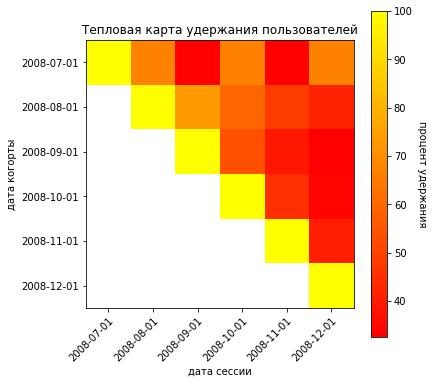

In [28]:
# строим тепловую карту
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(pv, cmap='autumn')
# создаем цветовую легенду 
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('процент удержания', rotation=-90, va="bottom")
# создаем подписи данных
ax.set_xticks(np.arange(len(pv.columns)), labels=pv.columns)
ax.set_yticks(np.arange(len(pv.index)), labels=pv.index)

# поворачиваем нижние подписи на 45 градусо для удобства
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
# создаем подписи осей
plt.xlabel('дата сессии')
plt.ylabel('дата когорты')
#создаем заголовок карты
plt.title('Тепловая карта удержания пользователей')
plt.show()

На тепловой карте видна аномалия в когорте от июля 2008 - вместо снижения кол-ва пользователей со временем, мы наблюдаем волнобразное изменение: кол-во пользователей то меньше, то больше.
Причины:
1. при маленьком кол-ве пользователей в когорте любое изменение приводит к очень большим колебаниям

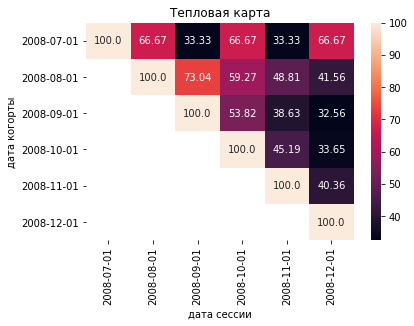

In [29]:
import seaborn as sns
sns.heatmap(pv, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.xlabel('дата сессии')
plt.ylabel('дата когорты')
plt.title('Тепловая карта') # название графика
plt.show() 

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [30]:
# напишите запрос
query = '''
WITH cur_inf AS (
SELECT DISTINCT EXTRACT('month' FROM creation_date)::int AS creation_month,
       count(id) OVER (PARTITION BY EXTRACT('month' FROM creation_date)) AS posts_count 
FROM  stackoverflow.posts 
WHERE EXTRACT('month' FROM creation_date) IN (9,10,11,12)
ORDER BY creation_month 
      )
SELECT *,
       round((posts_count - lag(posts_count) OVER ()) * 100.0 / lag(posts_count) OVER () , 2)  AS percentage
FROM cur_inf

'''

df11 = pd.read_sql_query(query, con=engine)

In [31]:
df11

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

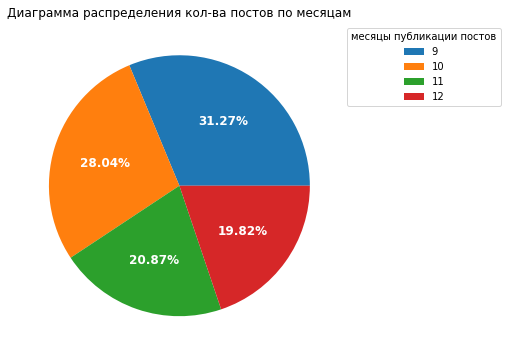

In [32]:
# постройте круговую диаграмму с количеством постов по месяцам
fig1, ax = plt.subplots(figsize=(6,6)) # устанавливаем размер диаграммы
wedges, texts, autotexts =ax.pie(df11['posts_count'], labels=df11['creation_month'], autopct='%1.2f%%', textprops=dict(color="w")) # диаграмма с подписями белого цвета
plt.setp(autotexts, size=12, weight="bold")   # устанавливаем размер подписей данных на диаграмме
# легеду диаграммы
ax.legend(wedges, df11['creation_month'],
          title='месяцы публикации постов',
          loc='upper left',
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Диаграмма распределения кол-ва постов по месяцам')  # заголовок диаграммы
plt.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [33]:
# напишите запрос
query = '''
WITH champ AS (
SELECT DISTINCT first_value(user_id) OVER() AS post_qty_champ
FROM (
SELECT DISTINCT user_id,
	   count(id) OVER (PARTITION BY user_id) AS posts_qty
FROM stackoverflow.posts	
ORDER BY 2 DESC 
     ) AS inf
)
SELECT DISTINCT extract('week' FROM creation_date)::int AS week_creation,
       max(creation_date) OVER (PARTITION BY extract('week' FROM creation_date)) AS creation_date 
FROM stackoverflow.posts p
JOIN champ AS ch ON p.user_id = ch.post_qty_champ
WHERE date_trunc('month', creation_date)::date = '2008-10-01'
ORDER BY 1
'''

df12 = pd.read_sql_query(query, con=engine)

In [34]:
df12

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
